# Convolution Neural Net (CNN)
to detect apples

# Imports

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import modules.cosmos_functions as cf

import pprint
import random
import torch
import torchvision
import torch.nn.functional as FF
import torchvision.transforms.functional as F
import torchvision.transforms as T
import wandb

from datetime import datetime
from os import listdir, path
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from tqdm import tqdm

In [17]:
# set the device

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
x = torch.ones(1, device=device)

print(f"Device is '{device}' Thus a tensor will look like this: {x}")

Device is 'mps' Thus a tensor will look like this: tensor([1.], device='mps:0')


In [18]:
import matplotlib.pyplot as plt


def reverse_normalize(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = image.clone()
    for i in range(3):
        image[i] = (image[i] * std[i]) + mean[i]
    return image

def show_batch(train_d, test_d, val_d):
    # Get a batch of data from the DataLoader
    data_train = next(iter(train_d))
    data_test = next(iter(test_d))
    data_val = next(iter(val_d))

    # Set the savefig.bbox parameter to 'tight'
    plt.rcParams["savefig.bbox"] = 'tight'

    # Retrieve the first tensor and its corresponding label
    image_train = data_train[0][0]
    image_test = data_test[0][0]
    image_val = data_val[0][0]
    label_train = data_train[1][0]
    label_test = data_test[1][0]
    label_val = data_val[1][0]

    # Reverse the normalization of the images
    image_train = reverse_normalize(image_train)
    image_test = reverse_normalize(image_test)
    image_val = reverse_normalize(image_val)

    # Convert the image tensors to NumPy arrays and transpose the dimensions
    np_image_train = image_train.permute(1, 2, 0).numpy()
    np_image_test = image_test.permute(1, 2, 0).numpy()
    np_image_val = image_val.permute(1, 2, 0).numpy()

    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3)

    # Display the image in the first subplot
    axes[0].imshow(np_image_train)
    axes[0].set_title(f'{label_train}, {image_train.shape}')

    # Display the image in the second subplot
    axes[1].imshow(np_image_test)
    axes[1].set_title(f'{label_test}, {image_test.shape}')

    # Display the image in the third subplot
    axes[2].imshow(np_image_val)
    axes[2].set_title(f'{label_val}, {image_val.shape}')

    # Adjust spacing between subplots to prevent overlap
    fig.tight_layout()

    # Show the plot
    plt.show()


In [19]:
# function to determine accuracy 

def evaluate_accuracy(logits, y_true):
    # get index with the largest logit value PER OBSERVATION
    _, y_pred = torch.max(logits, dim=1)

    # calculate proportion of correct prediction
    correct_pred = (y_pred == y_true).float()  # PyCharm error Unresolved attribute reference 'float' for class 'bool'
    acc = correct_pred.sum() / len(correct_pred)

    return acc * 100

In [20]:
# function to train the model

def train(model, train_loader, val_loader, criterion, optimizer, n_epochs, model_file_name='model.pt',local_save_path='storage/data/generated'):
    # initialize container variable for model performance results per epoch
    history = {
        'n_epochs': n_epochs,
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }   

    # initialize tracker for minimum validation loss and maxiumum validation accuracy
    val_loss_min = np.Inf
    val_loss_epoch = 0
    val_acc_max = 0.0
    val_acc_epoch = 0
    best_results = {
        'val_loss_min': val_loss_min,
        'val_loss_epoch': val_loss_epoch,
        'val_acc_max': val_acc_max,
        'val_acc_epoch': val_acc_epoch
        }    

    model_file_name_loss = f'{str(model_file_name[:-3])}_loss.pt'
    model_file_name_acc = f'{str(model_file_name[:-3])}_acc.pt'
    final_model_file_name = f'{str(model_file_name[:-3])}_final.pt'
    locally_saved_path = local_save_path   

    file_data = { 
                'local_save_path' : locally_saved_path,
                'min_loss_file' : model_file_name_loss,
                'max_acc_file' : model_file_name_acc,
                'final_epoch_file' : final_model_file_name
                  }
    
    model_safe_loss = f'../{locally_saved_path}/{model_file_name_loss}'
    model_safe_acc = f'../{locally_saved_path}/{model_file_name_acc}'
    model_safe_final = f'../{locally_saved_path}/{final_model_file_name}'

    # loop per epoch
    for epoch in tqdm(range(n_epochs)):
        
        # initialize tracker for training performance
        train_acc = 0
        train_loss = 0

        ###################
        # train the model #
        ###################

        # prepare model for training
        model.train()

        # loop for each batch
        for data, target in train_loader:
            # move data to device
            data, target = data.to(device), target.to(device)
            
            # STEP 1: clear gradients
            optimizer.zero_grad()
            # STEP 2: forward pass
            output = model(data)
            # STEP 3: calculate the loss
            loss = criterion(output, target)
            # STEP 4: backward pass
            loss.backward()
            # STEP 5: perform parameter update
            optimizer.step()
            # STEP 6: accumulate training loss and accuracy
            train_loss += loss.item() * data.size(0)
            acc = evaluate_accuracy(output, target)
            train_acc += acc.item() * data.size(0)

        ######################
        # validate the model #
        ######################

        # disable gradient calculation
        with torch.no_grad():
            # initialize tracker for validation performance
            val_acc = 0
            val_loss = 0

            # prepare model for evaluation
            model.eval()

            # loop for each batch
            for data, target in val_loader:
                # move data to device
                data, target = data.to(device), target.to(device)
                # STEP 1: forward pass
                output = model(data)
                # STEP 2: calculate the loss
                loss = criterion(output, target)
                # STEP 3: accumulate validation loss and accuracy
                val_loss += loss.item() * data.size(0)
                acc = evaluate_accuracy(output, target)
                val_acc += acc.item() * data.size(0)


        ####################
        # model evaluation #
        ####################

        # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        val_loss /= len(val_loader.sampler)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # calculate average accuracy over an epoch
        train_acc /= len(train_loader.sampler)
        val_acc /= len(val_loader.sampler)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # print training progress per epoch
        print(f'Epoch {epoch+1:03} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}')

        # save model if validation loss has decreased
        if val_loss <= val_loss_min:
            print(
                f'Validation loss decreased ({val_loss_min:.5f} --> {val_loss:.5f})  Saving model to {model_file_name}...')
            

            torch.save(model.state_dict(), model_safe_loss)
            val_loss_min = val_loss
            best_results['val_loss_min'] = val_loss_min
            best_results['val_loss_epoch'] = epoch+1
        
        # save model if validation accuracy has decreased
        if val_acc >= val_acc_max:
            print(
                f'Validation accuracy increased ({val_acc_max:.5f} --> {val_acc:.5f})  Saving model to {model_file_name}...')
              
            torch.save(model.state_dict(), model_safe_acc)
            val_acc_max = val_acc
            best_results['val_acc_max'] = val_acc_max
            best_results['val_acc_epoch'] = epoch+1

        # log metrics to wandb
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_acc": train_acc, "val_acc": val_acc})

    
    torch.save(model.state_dict(), model_safe_final)

    results = best_results, history, file_data
    
    # return model performance history
    return results

In [21]:
# load the dataset
dataset_path = "../storage/images/apple_disease_classification/Train"
# transform and normalize the data
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(dataset_path, transform=transform)


dataset.class_to_idx
pp = pprint.PrettyPrinter(indent=1)  # Create a PrettyPrinter instance with an indentation of 1 space
pp.pprint(dataset.class_to_idx)  # Use the pprint method to print the dictionary



{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}


In [22]:
# create the test, train and validation set and the dataloader

# setup split data 
dataset_size = len(dataset)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


# Set the seed for the generator
seed = 42
generator = torch.Generator().manual_seed(seed)

# Calculate the number of samples for each split
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)


# Define the batch size for the DataLoader
batch_size = 128

# Create the DataLoader to load the dataset in batches
train_d = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_d = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_d = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# print the shape of the 1st image in the dataset
print(train_dataset[0][0].shape)

# # Show the 1st img in the dataset
# show_batch(train_d, test_d,val_d)
# print(train_dataset[0][0])

torch.Size([3, 64, 64])


In [23]:
# define the CNN model

class CNN(nn.Module):
    
    #-------------------------------------------------------
    
    def __init__(self, dropout=0):
        self.dropout = dropout
        

        # Because we inherit from Module base class
        super().__init__()
        
        # RGB input, 6 filters, kernel of 5 x 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # Filter is 2 x 2 with a stride of 2 (defined once, used two times)
        self.pool = nn.MaxPool2d(2, 2)
        
        # in_channels = 6 because self.conv1 output has 6 channels
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Fully connected layer matched on output of conv2 layer
        self.fc1 = nn.Linear(16 * 13 * 13, 120)  # 64x64
        # self.fc1 = nn.Linear(16 * 56 * 56, 120)  # 224x224
        
        # Dropout layer1
        self.dropout1 = nn.Dropout(self.dropout)    

        # Dropout layer2
        self.dropout2 = nn.Dropout(self.dropout)

        # Fully connected layer
        self.fc2 = nn.Linear(120, 84)
        
        # We only have 2 labels
        self.fc3 = nn.Linear(84, 4)
        
    #-------------------------------------------------------
        
    def forward(self, x):
        
        # Convolution with relu layers
        x = self.pool(FF.relu(self.conv1(x)))
        x = self.pool(FF.relu(self.conv2(x)))
        
        # To match the output of the conv2 layer onto the first fully connected layer
        # Like reshape() but makes no copy (reuses underlaying data)
        x = x.view(-1, 16 * 13 * 13)
        
        # Fully connected layers
        x = FF.relu(self.fc1(x))
        x = self.dropout1(x)
        x = FF.relu(self.fc2(x))
        x = self.dropout2(x)
        
        # No activation on final layer 
        return self.fc3(x)


In [24]:
# set the hyperparameters and the model

# hyperparameters
learning_rate = 0.01
epochs = 6
momentum = 0.9
total_epochs =0
dropout = 0.3


# model parameters

model = CNN(dropout=dropout) # Create the model
model.to(device) # set model to device
model.train() # set model to train mode

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# loss function
criterion = nn.CrossEntropyLoss()   # Define the loss function  
 
 # set the loaders to the correct names for the training loop
train_loader = train_d
val_loader = val_d

# set epochloss to empty list
epoch_loss = []
# create dictionairies for the hyperparameters and model parameters
hyperparameters = { 'learning_rate' : learning_rate, 'epochs' : epochs, 'momentum' : momentum, 'dropout' : dropout}
model_parameters = { 'model' : 'cnn', 'optimizer' : 'SGD', 'criterion' : 'CrossEntropyLoss'}  # 'model' : model, 'optimizer' : optimizer, 'criterion' : criterion
parameters = {**hyperparameters, **model_parameters}    # merge the two dictionairies
pp = pprint.PrettyPrinter(indent=1)  


pp.pprint(f'parameters: {parameters}')

("parameters: {'learning_rate': 0.01, 'epochs': 6, 'momentum': 0.9, 'dropout': "
 "0.3, 'model': 'cnn', 'optimizer': 'SGD', 'criterion': 'CrossEntropyLoss'}")


In [25]:
# the training loop
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
userAccountID = cf.settings['userAccountID']
saveFileName = f'{timestamp}_{userAccountID}.pt'

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config= parameters
)

history = train(
    model, train_loader, val_loader, criterion, optimizer, n_epochs=epochs,
    model_file_name=saveFileName
)

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

print()
print(f'best results: {history[0]}')
print()
print(f'alot is: {history[1]}')
print()
print(f'save path = {history[2]}')

 17%|█▋        | 1/6 [00:17<01:27, 17.46s/it]

Epoch 001 | Train Loss: 1.38160 | Val Loss: 1.39098 | Train Acc: 26.59 | Val Acc: 21.05
Validation loss decreased (inf --> 1.39098)  Saving model to 20230607-081412_pinky.pt...
Validation accuracy increased (0.00000 --> 21.05263)  Saving model to 20230607-081412_pinky.pt...


 33%|███▎      | 2/6 [00:34<01:09, 17.38s/it]

Epoch 002 | Train Loss: 1.37437 | Val Loss: 1.38415 | Train Acc: 34.46 | Val Acc: 26.32
Validation loss decreased (1.39098 --> 1.38415)  Saving model to 20230607-081412_pinky.pt...
Validation accuracy increased (21.05263 --> 26.31579)  Saving model to 20230607-081412_pinky.pt...


 50%|█████     | 3/6 [00:52<00:51, 17.32s/it]

Epoch 003 | Train Loss: 1.36486 | Val Loss: 1.36843 | Train Acc: 40.45 | Val Acc: 26.32
Validation loss decreased (1.38415 --> 1.36843)  Saving model to 20230607-081412_pinky.pt...
Validation accuracy increased (26.31579 --> 26.31579)  Saving model to 20230607-081412_pinky.pt...


 67%|██████▋   | 4/6 [01:09<00:34, 17.37s/it]

Epoch 004 | Train Loss: 1.34141 | Val Loss: 1.32070 | Train Acc: 43.45 | Val Acc: 33.33
Validation loss decreased (1.36843 --> 1.32070)  Saving model to 20230607-081412_pinky.pt...
Validation accuracy increased (26.31579 --> 33.33334)  Saving model to 20230607-081412_pinky.pt...


 83%|████████▎ | 5/6 [01:26<00:17, 17.35s/it]

Epoch 005 | Train Loss: 1.28702 | Val Loss: 1.27366 | Train Acc: 40.45 | Val Acc: 33.33
Validation loss decreased (1.32070 --> 1.27366)  Saving model to 20230607-081412_pinky.pt...
Validation accuracy increased (33.33334 --> 33.33334)  Saving model to 20230607-081412_pinky.pt...


100%|██████████| 6/6 [01:44<00:00, 17.34s/it]

Epoch 006 | Train Loss: 1.24417 | Val Loss: 1.26652 | Train Acc: 38.20 | Val Acc: 36.84
Validation loss decreased (1.27366 --> 1.26652)  Saving model to 20230607-081412_pinky.pt...
Validation accuracy increased (33.33334 --> 36.84211)  Saving model to 20230607-081412_pinky.pt...


train_acc,▁▄▇█▇▆
train_loss,██▇▆▃▁
val_acc,▁▃▃▆▆█
val_loss,██▇▄▁▁
train_acc,38.20225
train_loss,1.24417
val_acc,36.84211
val_loss,1.26652



best results: {'val_loss_min': 1.266523003578186, 'val_loss_epoch': 6, 'val_acc_max': 36.842105865478516, 'val_acc_epoch': 6}

alot is: {'n_epochs': 6, 'train_loss': [1.381599339206567, 1.37437086828639, 1.3648646877946031, 1.3414113374238603, 1.287018781744139, 1.2441719841867798], 'val_loss': [1.3909767866134644, 1.384151577949524, 1.3684277534484863, 1.3207005262374878, 1.2736624479293823, 1.266523003578186], 'train_acc': [26.591760328199978, 34.4569289389621, 40.44943825939622, 43.445692912469646, 40.449438187959935, 38.202247291022026], 'val_acc': [21.052631378173828, 26.3157901763916, 26.3157901763916, 33.333335876464844, 33.333335876464844, 36.842105865478516]}

save path = {'local_save_path': 'storage/data/generated', 'min_loss_file': '20230607-081412_pinky_loss.pt', 'max_acc_file': '20230607-081412_pinky_acc.pt', 'final_epoch_file': '20230607-081412_pinky_final.pt'}


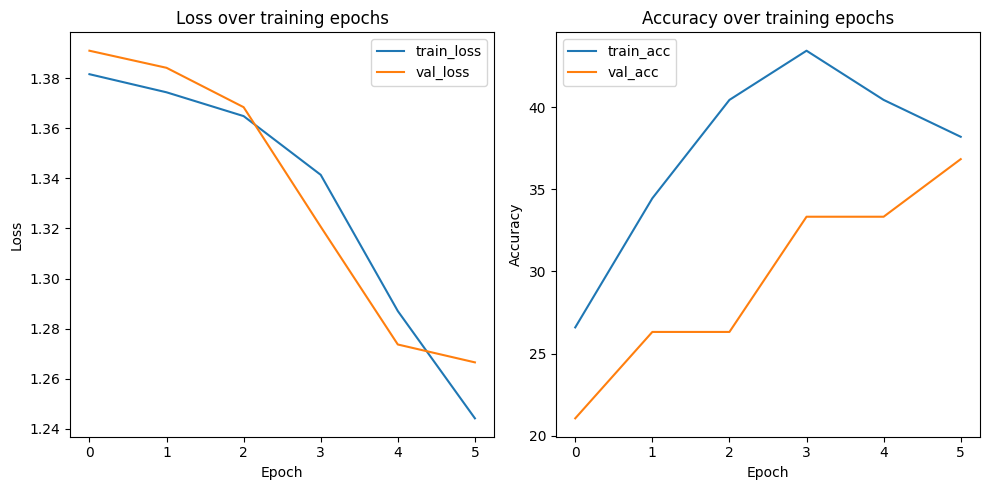

In [26]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the training and validation loss
axs[0].plot(history[1]['train_loss'], label='train_loss')
axs[0].plot(history[1]['val_loss'], label='val_loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over training epochs')
axs[0].legend()

# Plot the training and validation accuracy
axs[1].plot(history[1]['train_acc'], label='train_acc')
axs[1].plot(history[1]['val_acc'], label='val_acc')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy over training epochs')
axs[1].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [27]:
# show the save paths from history
history

({'val_loss_min': 1.266523003578186,
  'val_loss_epoch': 6,
  'val_acc_max': 36.842105865478516,
  'val_acc_epoch': 6},
 {'n_epochs': 6,
  'train_loss': [1.381599339206567,
   1.37437086828639,
   1.3648646877946031,
   1.3414113374238603,
   1.287018781744139,
   1.2441719841867798],
  'val_loss': [1.3909767866134644,
   1.384151577949524,
   1.3684277534484863,
   1.3207005262374878,
   1.2736624479293823,
   1.266523003578186],
  'train_acc': [26.591760328199978,
   34.4569289389621,
   40.44943825939622,
   43.445692912469646,
   40.449438187959935,
   38.202247291022026],
  'val_acc': [21.052631378173828,
   26.3157901763916,
   26.3157901763916,
   33.333335876464844,
   33.333335876464844,
   36.842105865478516]},
 {'local_save_path': 'storage/data/generated',
  'min_loss_file': '20230607-081412_pinky_loss.pt',
  'max_acc_file': '20230607-081412_pinky_acc.pt',
  'final_epoch_file': '20230607-081412_pinky_final.pt'})

save the data to azure cosmos NoSQL database


In [28]:
local_saved_path= list(history[2].values())[0]
model_file_name_loss = list(history[2].values())[1]
print(f'{list(history[2].values())[0]}/{list(history[2].values())[1]}')

model_file_name_loss= f'{list(history[2].values())[0]}/{list(history[2].values())[1]}'
print(model_file_name_loss)

storage/data/generated/20230607-081412_pinky_loss.pt
storage/data/generated/20230607-081412_pinky_loss.pt


In [29]:
import time

model_file_name_loss= f'../{list(history[2].values())[0]}/{list(history[2].values())[1]}'
model_file_name_acc = f'../{list(history[2].values())[0]}/{list(history[2].values())[2]}'
model_file_name_final = f'../{list(history[2].values())[0]}/{list(history[2].values())[3]}'
# model_file_name_loss= './20230605-103225_pinky_loss.pt' 
# model_file_name_acc = './20230605-103225_pinky_acc.pt'
# model_file_name_final = './20230605-103225_pinky_final.pt'
print(model_file_name_loss)
print(model_file_name_acc)
print(model_file_name_final)


pulled_loss = cf.save_data(model_file_name_loss, parameters, history, )
time.sleep(2)
pulled_acc = cf.save_data(model_file_name_acc, parameters, history)
time.sleep(2)
pulled_final = cf.save_data(model_file_name_final, parameters, history)

../storage/data/generated/20230607-081412_pinky_loss.pt
../storage/data/generated/20230607-081412_pinky_acc.pt
../storage/data/generated/20230607-081412_pinky_final.pt
Item with id '20230607_081602_pinky' created
Item with id '20230607_081605_pinky' created
Item with id '20230607_081608_pinky' created


test


In [30]:
print(pulled_final)

20230607_081608_pinky


# WIP loader loads a wrong data type.